# Removing ? in sleep grid and other things

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Calculating Min and Max Heart Rates

needs heart_rate_grid.pkl and the two fitness test spreadsheets in data folder named spreadsheet1.xlsw and spreadsheet2.xlsw

In [2]:
with open('heart_rate_grid.pkl', 'rb') as file:
    heart_rate = pickle.load(file)

In [117]:
# example usage of heart_rate
soldID = '00a7a796-c572-44d7-a950-7f6bca4a4394'
print(f'HR recorded weeks: {heart_rate[soldID].keys()}')
heart_rate[soldID][35].head()
# weeks:  4, 35, 36, 50, 51

HR recorded weeks: dict_keys([4, 35, 36, 50, 51])


,userId,dailiessummaryId,pulse,datetime,WeekNumber,date
0,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:20:15,35,2022-09-04
1,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:20:30,35,2022-09-04
2,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:20:45,35,2022-09-04
3,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:21:00,35,2022-09-04
4,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:21:15,35,2022-09-04


min hr

In [93]:
# min hr: 5 percentile
percentile_5_hrs = {}
min_avg_hrs = {}
for soldier_id, weekly_data in heart_rate.items():
    daily_percentile_5_hr = []
    for week, df in weekly_data.items():
        df['date'] = df['datetime'].dt.date  # Extract date part from datetime
        daily_groups = df.groupby('date')  # Group by date
        for date, group in daily_groups:
            percentile_5 = np.percentile(group['pulse'], 5)  # Calculate 5th percentile for the day's heart rates
            daily_percentile_5_hr.append(percentile_5)
    percentile_5_hrs[soldier_id] = daily_percentile_5_hr
    min_avg_hrs[soldier_id] = np.median(daily_percentile_5_hr)
print(f'average min hr across all soldiers: {np.average(list(min_avg_hrs.values()))}')

average min hr across all soldiers: 59.06726190476191


In [94]:
# example
percentile_5_hrs['00a7a796-c572-44d7-a950-7f6bca4a4394'] # each entry corresponds to a day

[87.0, 60.0, 79.0, 70.0, 47.0, 50.0, 46.0, 77.0, 60.1, 71.0]

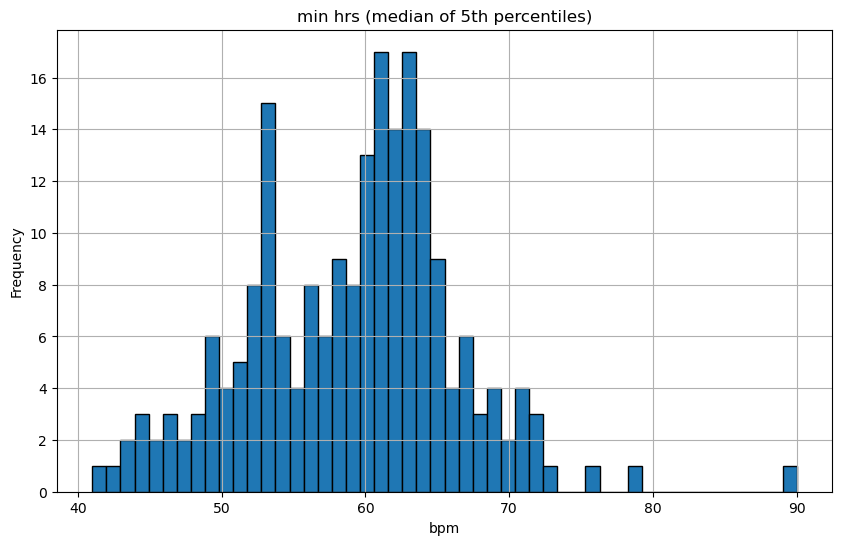

In [103]:
# graph
median_values = list(min_avg_hrs.values())

plt.figure(figsize=(10, 6))
plt.hist(median_values, bins=50, edgecolor='black')
plt.title('min hrs (median of 5th percentiles)')
plt.xlabel('bpm')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [98]:
# getting the dates of the fitness tests -> union_dates
import datetime
def convert_unix_to_datetime(unix_timestamp):
    return datetime.datetime.fromtimestamp(unix_timestamp)

df1 = pd.read_excel('data/spreadsheet1.xlsx')
df2 = pd.read_excel('data/spreadsheet2.xlsx')
df1['date'] = pd.to_datetime(df1['date']).apply(lambda x: x.date())
df2['date'] = pd.to_datetime(df2['date']).apply(lambda x: x.date())
dates1 = df1['date'].dropna()
dates2 = df2['date'].dropna()
union_dates = pd.concat([df1['date'], df2['date']]).drop_duplicates().dropna().reset_index(drop=True)
print(f'number of dates in fitness test: {len(union_dates)}')
# set(union_dates)

number of dates in fitness test: 117


max hr

In [120]:
# calculating max hr: 99.5 percentile 
percentile_99_5_hrs = {}
max_avg_hrs = {}
min_samples = 500

union_dates_set = set(union_dates)
# union_dates_set = {datetime.date(2022, 9, 15)}  # test with individual date/s; (year, month, day)

for soldier_id, weekly_data in heart_rate.items():
    daily_percentile_99_5_hr = []
    for week, df in weekly_data.items():
        df['date'] = df['datetime'].dt.date  # Extract date part from datetime
        daily_groups = df.groupby('date')  # Group by date
        for date, group in daily_groups:
            # print(len(group)) # group is the df with the hr on the date for soldier_id
            # uncomment an 'if' and use
            if date in union_dates_set and len(group) > min_samples:  # fitness dates only
            # if len(group) > min_samples:  # all dates
            # if date not in union_dates_set and len(group) > min_samples:  # no fitness dates
            # if True:  # all dates and any size of group
                percentile_99_5 = np.percentile(group['pulse'], 99.5)  # Calculate 95th percentile for the day's heart rates
                daily_percentile_99_5_hr.append(percentile_99_5)
    percentile_99_5_hrs[soldier_id] = daily_percentile_99_5_hr
    if len(daily_percentile_99_5_hr):  # no divide by zero error
        max_avg_hrs[soldier_id] = np.median(daily_percentile_99_5_hr)

print(f'average max hr across all soldiers: {np.average(list(max_avg_hrs.values()))}')
print(f'num of soldiers with no data: {len(heart_rate.keys()) - len(max_avg_hrs.keys())}')

average max hr across all soldiers: 123.88335106382979
num of soldiers with no data: 69


In [111]:
# print the soldiers with their max hr
df_max_avg_hrs = pd.DataFrame.from_dict(max_avg_hrs, orient='index', columns=['max_hr'])
df_max_avg_hrs.reset_index(inplace=True)
df_max_avg_hrs.rename(columns={'index': 'soldier_id'}, inplace=True)
df_max_avg_hrs

,soldier_id,max_hr
0,00a7a796-c572-44d7-a950-7f6bca4a4394,123.0000
1,02a9bd9f-430e-4351-b1e7-9ae10b9413a3,132.0000
2,03406515-0b5e-4a5a-9ff1-a85c06513e60,138.0000
3,042e1305-faa2-4eb8-a833-d2181efdeb31,117.0000
4,050b5881-43e2-44c8-8964-148576d30359,123.5000
...,...,...
136,facdd015-3ab6-4dca-8c12-4fc3c008679e,121.0000
137,fbfa150b-4c62-412d-9e84-ef06e8495fc5,114.6825
138,fd486705-4873-4001-95f5-6f5bbf0d620f,140.0000
139,fd949638-b68e-4e68-b660-f31133ed2a19,104.0000


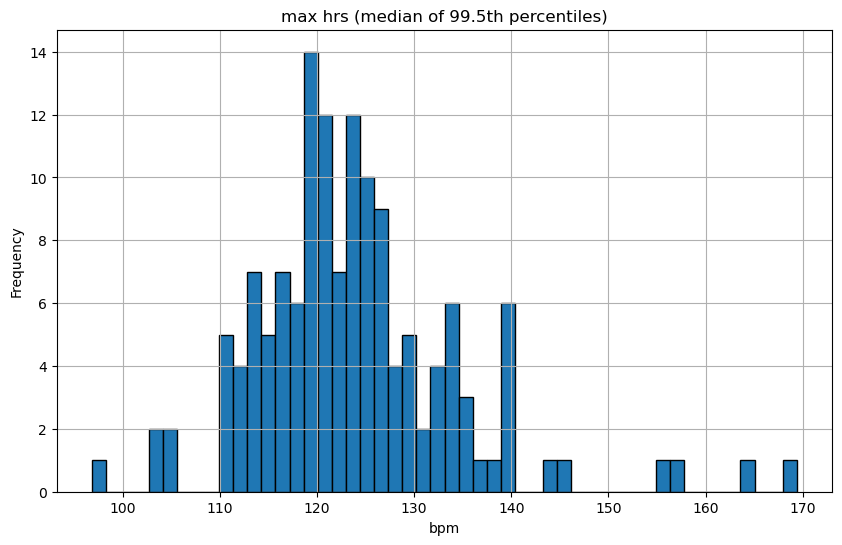

In [107]:
# graph
median_values = list(max_avg_hrs.values())

plt.figure(figsize=(10, 6))
plt.hist(median_values, bins=50, edgecolor='black')
plt.title('max hrs (median of 99.5th percentiles)')
plt.xlabel('bpm')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [128]:
# soldID = 'ba6e4cf9-b8f2-49a1-890e-5093d32a456e'
soldID = 'b810cc55-65f1-45fa-94fe-e28b8066cd01'
print(f'max hr for \'{soldID}\' is {max_avg_hrs[soldID]} bpm')
print('HR 99.5th percentile per day:')
# percentile_99_5_hrs[soldID].sort()
percentile_99_5_hrs[soldID]

max hr for 'b810cc55-65f1-45fa-94fe-e28b8066cd01' is 122.0 bpm
HR 99.5th percentile per day:


[139.0,
 110.0,
 147.0,
 112.0,
 118.0,
 122.0,
 121.0,
 187.0,
 174.0,
 120.0,
 169.0,
 164.0,
 82.0,
 137.0,
 116.0]

In [122]:
heart_rate[soldID][36]
# weeks: [2, 3, 4, 34, 35, 40, 42, 43, 44, 45, 46, 47, 48, 49]

,userId,dailiessummaryId,pulse,datetime,WeekNumber,date
0,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,67,2022-09-15 14:15:15,36,2022-09-15
1,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,67,2022-09-15 14:15:30,36,2022-09-15
2,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,67,2022-09-15 14:15:45,36,2022-09-15
3,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,67,2022-09-15 14:16:00,36,2022-09-15
4,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,69,2022-09-15 14:20:15,36,2022-09-15
5,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,69,2022-09-15 14:20:30,36,2022-09-15
6,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,69,2022-09-15 14:20:45,36,2022-09-15
7,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,69,2022-09-15 14:21:00,36,2022-09-15
8,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,83,2022-09-15 14:21:15,36,2022-09-15
9,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,83,2022-09-15 14:21:30,36,2022-09-15


## steps with zones

In [12]:
# making heart rate grids be by 1 minute, and not 15 seconds
resampled_heart_rate = {}

for soldier_id, weekly_data in heart_rate.items():
    resampled_heart_rate[soldier_id] = {}
    for week, df in weekly_data.items():
        df_copy = df.copy()
        df_copy.set_index('datetime', inplace=True)  # Set datetime as the index for resampling
        resampled_df = df_copy.resample('min').mean(numeric_only=True).dropna().reset_index()   # Resample to 1 minute intervals and take the mean
        resampled_df.reset_index(inplace=True)  # Reset the index to make datetime a column again
        resampled_df['WeekNumber'] = resampled_df['WeekNumber'].astype('int64')
        resampled_heart_rate[soldier_id][week] = resampled_df

In [9]:
heart_rate['00a7a796-c572-44d7-a950-7f6bca4a4394'][35]

,userId,dailiessummaryId,pulse,datetime,WeekNumber
0,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:20:15,35
1,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:20:30,35
2,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:20:45,35
3,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:21:00,35
4,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:21:15,35
...,...,...,...,...,...
3007,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6317b4d0-3cf0-6,87,2022-09-07 04:19:00,35
3008,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6317b4d0-3cf0-6,79,2022-09-07 04:19:15,35
3009,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6317b4d0-3cf0-6,79,2022-09-07 04:19:30,35
3010,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6317b4d0-3cf0-6,79,2022-09-07 04:19:45,35


In [24]:
resampled_heart_rate['00a7a796-c572-44d7-a950-7f6bca4a4394'].keys()

dict_keys([4, 35, 36, 50, 51])

In [6]:
with open('steps_grid.pkl', 'rb') as file:
    steps_grid = pickle.load(file)

In [25]:
steps_grid['00a7a796-c572-44d7-a950-7f6bca4a4394'][5]

,startTimeLocal,steps,userId,activeTimeInSeconds,distanceInMeters,speed,is_running
0,2023-02-05 00:00:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.0,0.0,False
1,2023-02-05 00:15:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.0,0.0,False
2,2023-02-05 00:30:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.0,0.0,False
3,2023-02-05 00:45:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.0,0.0,False
4,2023-02-05 01:00:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.0,0.0,False
...,...,...,...,...,...,...,...
222,2023-02-07 07:30:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.0,0.0,False
223,2023-02-07 07:45:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.0,0.0,False
224,2023-02-07 08:00:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.0,0.0,False
225,2023-02-07 08:15:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.0,0.0,False


In [104]:
# resampling steps to be 1 minute interval from 15 minute interval
heart_rate_zones = [60, 100, 130, 150, 170, 175]  # example hr zones

def get_hr_zone(hr, zones):
    if pd.isna(hr):
        return np.nan
    for i, zone in enumerate(zones):
        if hr < zone:
            return i
    return len(zones)

resampled_steps = {}

for user_id, weekly_data in steps_grid.items():
    resampled_steps[user_id] = {}
    for week, df_steps in weekly_data.items():
        df_steps_copy = df_steps.copy()
        df_steps_copy.set_index('startTimeLocal', inplace=True)
        # TODO bug, doesn't do 15 min interval at the end
        resampled_steps_df = df_steps_copy.resample('min').ffill().reset_index()  # Forward fill to resample to 1-minute intervals
        
        # Get corresponding heart rate data
        df_heart_rate = pd.DataFrame(columns=['datetime','pulse'])
        if user_id in resampled_heart_rate.keys() and week in resampled_heart_rate[user_id].keys():
            df_heart_rate = resampled_heart_rate[user_id][week]
            
        # Merge steps data with heart rate data
        merged_df = pd.merge(resampled_steps_df, df_heart_rate, left_on='startTimeLocal', right_on='datetime', how='left')
        # Assign heart rate zones
        merged_df['HR_zone'] = merged_df['pulse'].apply(lambda x: get_hr_zone(x, heart_rate_zones))
        
        # Set HR_zone to 0 if distanceInMeters is 0
        merged_df.loc[merged_df['distanceInMeters'] == 0, 'HR_zone'] = 0
        
        # Drop unnecessary columns and reset index
        # merged_df = merged_df[['startTimeLocal', 'steps', 'userId', 'activeTimeInSeconds', 'distanceInMeters', 'speed', 'is_running', 'HR_zone']]
        merged_df = merged_df[['startTimeLocal', 'userId', 'HR_zone','pulse']]
        
        resampled_steps[user_id][week] = merged_df

In [105]:
resampled_steps['00a7a796-c572-44d7-a950-7f6bca4a4394'][35]

,startTimeLocal,userId,HR_zone,pulse
0,2022-09-04 09:15:00,00a7a796-c572-44d7-a950-7f6bca4a4394,NaN,NaN
1,2022-09-04 09:16:00,00a7a796-c572-44d7-a950-7f6bca4a4394,NaN,NaN
2,2022-09-04 09:17:00,00a7a796-c572-44d7-a950-7f6bca4a4394,NaN,NaN
3,2022-09-04 09:18:00,00a7a796-c572-44d7-a950-7f6bca4a4394,NaN,NaN
4,2022-09-04 09:19:00,00a7a796-c572-44d7-a950-7f6bca4a4394,NaN,NaN
...,...,...,...,...
4016,2022-09-07 04:11:00,00a7a796-c572-44d7-a950-7f6bca4a4394,NaN,NaN
4017,2022-09-07 04:12:00,00a7a796-c572-44d7-a950-7f6bca4a4394,NaN,NaN
4018,2022-09-07 04:13:00,00a7a796-c572-44d7-a950-7f6bca4a4394,NaN,NaN
4019,2022-09-07 04:14:00,00a7a796-c572-44d7-a950-7f6bca4a4394,NaN,NaN


In [81]:
resampled_heart_rate['00a7a796-c572-44d7-a950-7f6bca4a4394'][35]

,index,pulse,WeekNumber
datetime,,,
2022-09-04 09:20:00,0,83.00,35
2022-09-04 09:21:00,1,83.00,35
2022-09-04 09:22:00,2,83.00,35
2022-09-04 09:23:00,3,79.25,35
2022-09-04 09:24:00,4,73.20,35
...,...,...,...
2022-09-07 04:07:00,748,98.00,35
2022-09-07 04:08:00,749,103.00,35
2022-09-07 04:18:00,750,87.00,35


In [106]:
steps_grid['00a7a796-c572-44d7-a950-7f6bca4a4394'][35]

,startTimeLocal,steps,userId,activeTimeInSeconds,distanceInMeters,speed,is_running
0,2022-09-04 09:15:00,49,00a7a796-c572-44d7-a950-7f6bca4a4394,600,40.79,1.147219,False
1,2022-09-04 09:30:00,103,00a7a796-c572-44d7-a950-7f6bca4a4394,900,85.76,1.715200,False
2,2022-09-04 09:45:00,29,00a7a796-c572-44d7-a950-7f6bca4a4394,900,24.15,1.449000,False
3,2022-09-04 10:00:00,172,00a7a796-c572-44d7-a950-7f6bca4a4394,900,259.72,3.087240,False
4,2022-09-04 10:15:00,169,00a7a796-c572-44d7-a950-7f6bca4a4394,900,203.43,1.743000,False
...,...,...,...,...,...,...,...
264,2022-09-07 03:15:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.00,0.000000,False
265,2022-09-07 03:30:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.00,0.000000,False
266,2022-09-07 03:45:00,0,00a7a796-c572-44d7-a950-7f6bca4a4394,900,0.00,0.000000,False
267,2022-09-07 04:00:00,64,00a7a796-c572-44d7-a950-7f6bca4a4394,900,53.29,1.065800,False


something with sleeping grid ???

In [124]:
with open('sleeping.pkl', 'rb') as file:
    sleeping = pickle.load(file)

In [125]:
soldierID = 'c062c143-35bd-48e8-a711-12b2909230f0'
print(steps_grid[soldierID].keys())
print(heart_rate[soldierID].keys())
print(sleeping[soldierID].keys())

dict_keys([7, 8, 9, 34, 35])
dict_keys([7, 8, 9, 11, 34, 35, 36])
dict_keys([7, 35, 36])


In [126]:
sleeping.keys()

dict_keys(['00a7a796-c572-44d7-a950-7f6bca4a4394', '02a9bd9f-430e-4351-b1e7-9ae10b9413a3', '03406515-0b5e-4a5a-9ff1-a85c06513e60', '042e1305-faa2-4eb8-a833-d2181efdeb31', '050b5881-43e2-44c8-8964-148576d30359', '0793ab56-25e1-4b0b-9a9b-be573b682523', '091855dd-6b30-4e37-818d-6341a853d026', '091b0864-139b-41ce-b365-11831889a3c7', '0c80b148-0d19-4a71-9309-b86f1ab9f3ce', '0d31cc9d-31ea-4473-b513-3f477a73e708', '0f777005-330d-4d68-8960-9fe8f0501e3d', '0fa9bebd-47a8-4979-9ae4-54f8288dc150', '0fc41759-3017-42f4-b784-69f90f913954', '102d37b9-87fa-40cc-92ff-c88b9d7b2311', '1256e510-9559-47ff-8389-f76287ae974e', '1667c01c-6bf8-4983-b946-d174ae40e539', '16dfee60-03fa-4d81-982a-1ebaf812b3c5', '176d1f17-4353-4eb6-9543-6a645ff5bfd1', '184a8b74-e4ef-4f13-8759-c6fef09a5888', '1c4310c0-a707-4565-abba-cc948d0dd3e0', '207af7e1-9b5b-4296-a7fa-96b6d7f56339', '21b2fcc0-43aa-4160-9db3-2d57970266ec', '26a65472-fc32-418f-9859-1251410af466', '27ec307b-918c-4c9b-a3fa-157941b816f1', '29f6135a-5e81-4cde-92d6-4cfe